In [1]:
import time
import pandas as pd
import numpy as np
import cPickle as pickle

# Suppress convergence warning
import warnings
warnings.simplefilter("ignore")

# Machine Learning
import sklearn
import sklearn.ensemble
import sklearn.svm
import sklearn.preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
# Plot
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['figure.figsize'] = 8, 5.5

# Plot heat map of a 2D grid search
def plotGridResults2D(x, y, x_label, y_label, grid_scores):
    
    scores = [s[1] for s in grid_scores]
    scores = np.array(scores).reshape(len(x), len(y))

    plt.figure()
    plt.grid('off')
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.RdYlGn)
    plt.xlabel(y_label)
    plt.ylabel(x_label)
    plt.colorbar()
    plt.xticks(np.arange(len(y)), y, rotation=45)
    plt.yticks(np.arange(len(x)), x)
    plt.title('Validation accuracy')


def plotRoC(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.005])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

In [3]:
# import training dataset
start = time.time()
training = pickle.load(open('trainFinal.p', 'rb'))
training = training.sample(frac=1)
X_train = training.loc[:, training.columns[1:],]
y_train = training.loc[:, 'label']
end = time.time()
end - start

68.16040205955505

In [4]:
# import testing dataset
start = time.time()
testing = pickle.load(open('testFinal.p', 'rb'))
testing = testing.sample(frac=1)
X_test = testing.loc[:, training.columns[1:],]
y_test = testing.loc[:, 'label']
end = time.time()
end - start

8.223140001296997

In [5]:
# SVM CV training
start = time.time()
C_range = np.r_[np.logspace(-2, 9, 10)]
gamma_range = np.r_[np.logspace(-9, 2, 10)]
gridCoarse = GridSearchCV(sklearn.svm.SVC(C=1.0, kernel='rbf', class_weight='balanced', verbose=False, max_iter=50),
                    {'C' : C_range, 'gamma': gamma_range},
                   scoring='roc_auc', cv=10, n_jobs=4)
gridCoarse.fit(X_train, y_train)

C_best = np.round(np.log10(gridCoarse.best_params_['C']))
gamma_best = np.round(np.log10(gridCoarse.best_params_['gamma']))

# Fine grid
'''
Cfine_range = np.r_[np.logspace(C_best - 1, C_best + 1, 15)]
gammafine_range = np.r_[np.logspace(gamma_best - 2, gamma_best + 2, 15)]

gridFine = GridSearchCV(sklearn.svm.SVC(C=1.0, kernel='rbf', class_weight='balanced', verbose=False, max_iter=250),
                    {'C' : Cfine_range, 'gamma': gammafine_range},
                   scoring='roc_auc', cv=10, n_jobs=-1)
gridFine.fit(X_train, y_train)

svmbestClf = gridFine.best_estimator_
svmbestClf.probability = True
'''
end = time.time()
end - start

1220.5029830932617

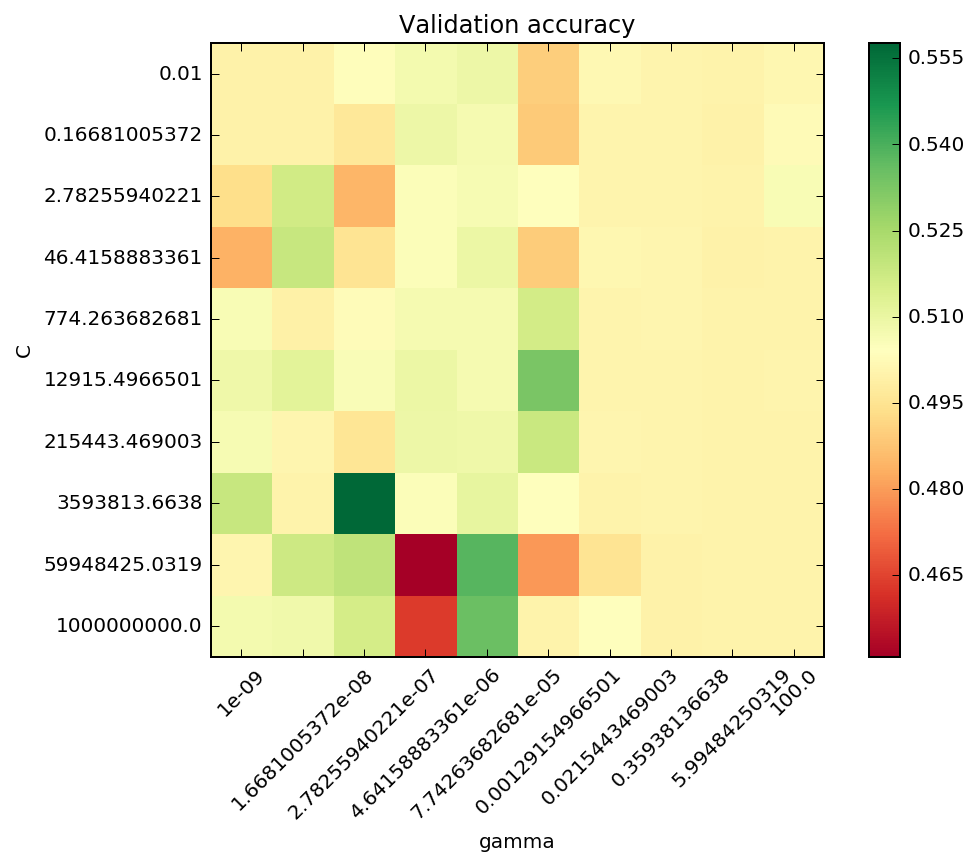

In [6]:
# plot coarse grid
plotGridResults2D(C_range, gamma_range, 'C', 'gamma', gridCoarse.grid_scores_)

In [ ]:
# plot fine grid
#plotGridResults2D(Cfine_range, gammafine_range, 'C', 'gamma', gridFine.grid_scores_)

In [7]:
svmbestClf = gridCoarse.best_estimator_
svmbestClf.probability = True

             precision    recall  f1-score   support

        0.0       0.80      0.99      0.89     15216
        1.0       0.89      0.18      0.30      4622

avg / total       0.82      0.80      0.75     19838



array([[15116,   100],
       [ 3802,   820]])

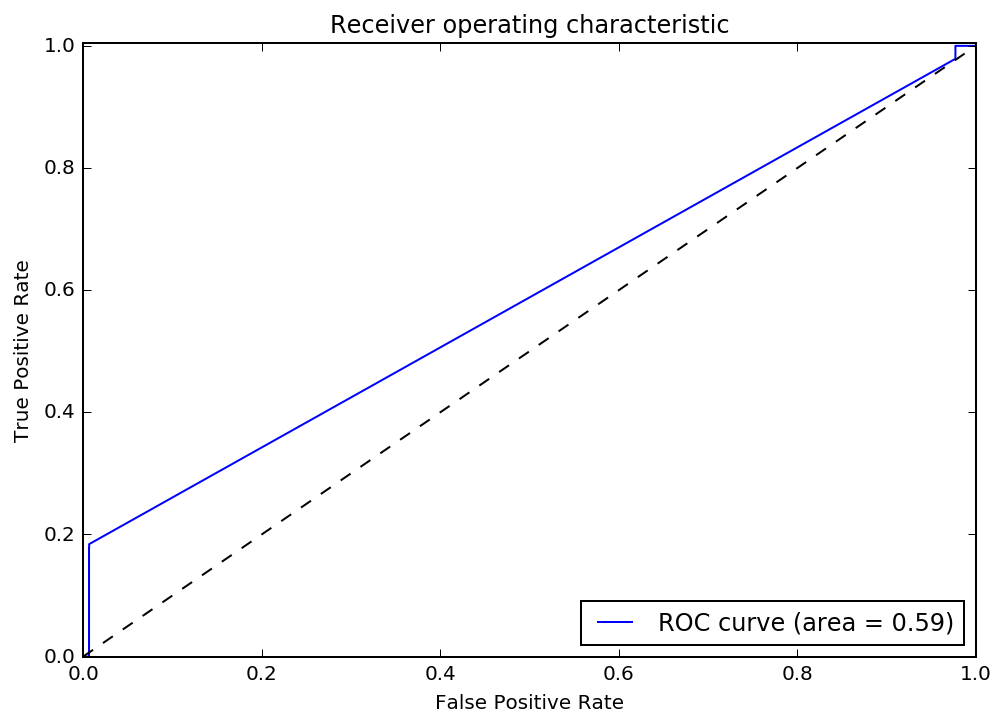

In [8]:
svmbestClf.fit(X_train, y_train)
y_pred = svmbestClf.predict(X_test)

print sklearn.metrics.classification_report(y_test, y_pred)

# Predict scores
y_score = svmbestClf.predict_proba(X_test)[:, 1]

# Plot ROC
sfpr, stpr, _ = roc_curve(y_test, y_score)

plotRoC(sfpr, stpr)

confusion_matrix(y_test, y_pred)

336.87314105033875

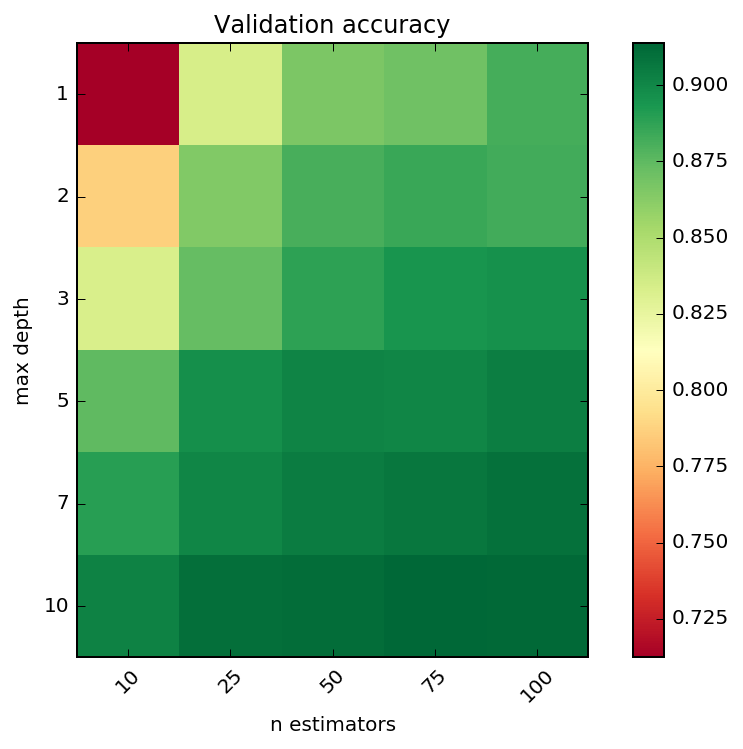

In [9]:
######## Random Forest ##########
start = time.time()
depth_range = np.array([1, 2, 5, 10, 15, 25, 50])
ntree_range = np.array([10, 25, 50, 75, 100, 200])
grid = GridSearchCV(sklearn.ensemble.RandomForestClassifier(n_estimators=50, max_depth=None,
                                                                   max_features='auto', class_weight='balanced'),
                    {'max_depth' : depth_range,
                    'n_estimators' : ntree_range},
                   cv=10, n_jobs=4, scoring='roc_auc') #sklearn.cross_validation.StratifiedKFold(y_train, 10)
grid.fit(X_train, y_train)

plotGridResults2D(depth_range, ntree_range, 'max depth', 'n estimators', grid.grid_scores_)

rbestClf = grid.best_estimator_
#print rbestClf
end = time.time()
end - start

             precision    recall  f1-score   support

        0.0       1.00      0.98      0.99     15216
        1.0       0.94      1.00      0.97      4622

avg / total       0.99      0.99      0.99     19838



array([[14923,   293],
       [    0,  4622]])

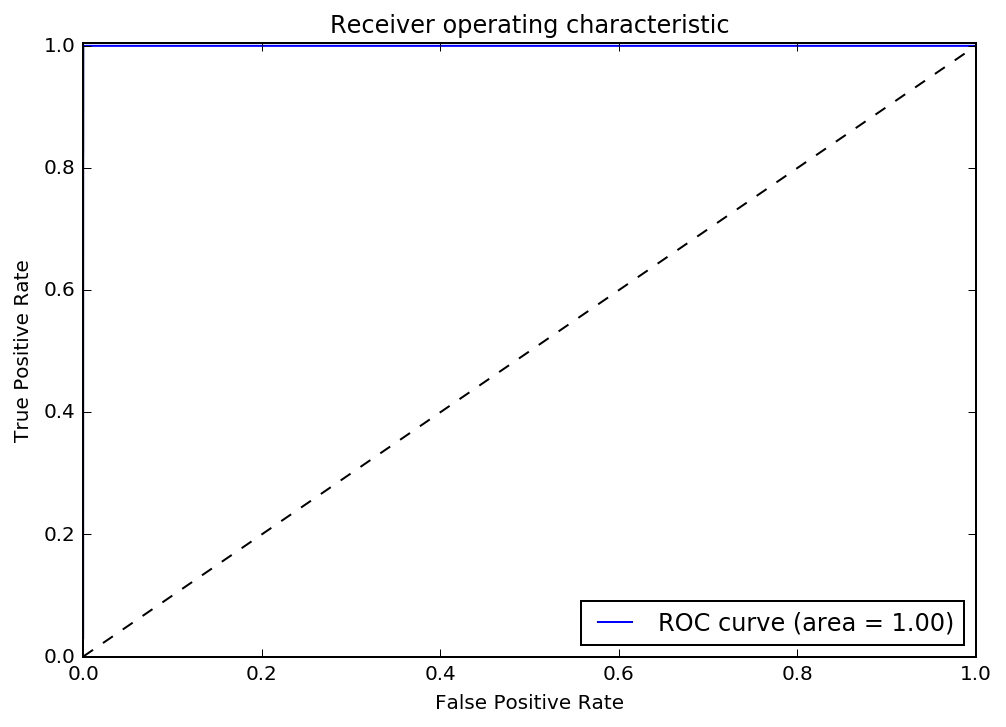

In [11]:
# Learn on train for test
rbestClf.fit(X_train, y_train)
y_pred = rbestClf.predict(X_test)

# Classification report
print sklearn.metrics.classification_report(y_test, y_pred)

y_score = rbestClf.predict_proba(X_test)[:,1]

# ROC
rfpr, rtpr, _ = roc_curve(y_test, y_score)

plotRoC(rfpr, rtpr)

confusion_matrix(y_test, y_pred)

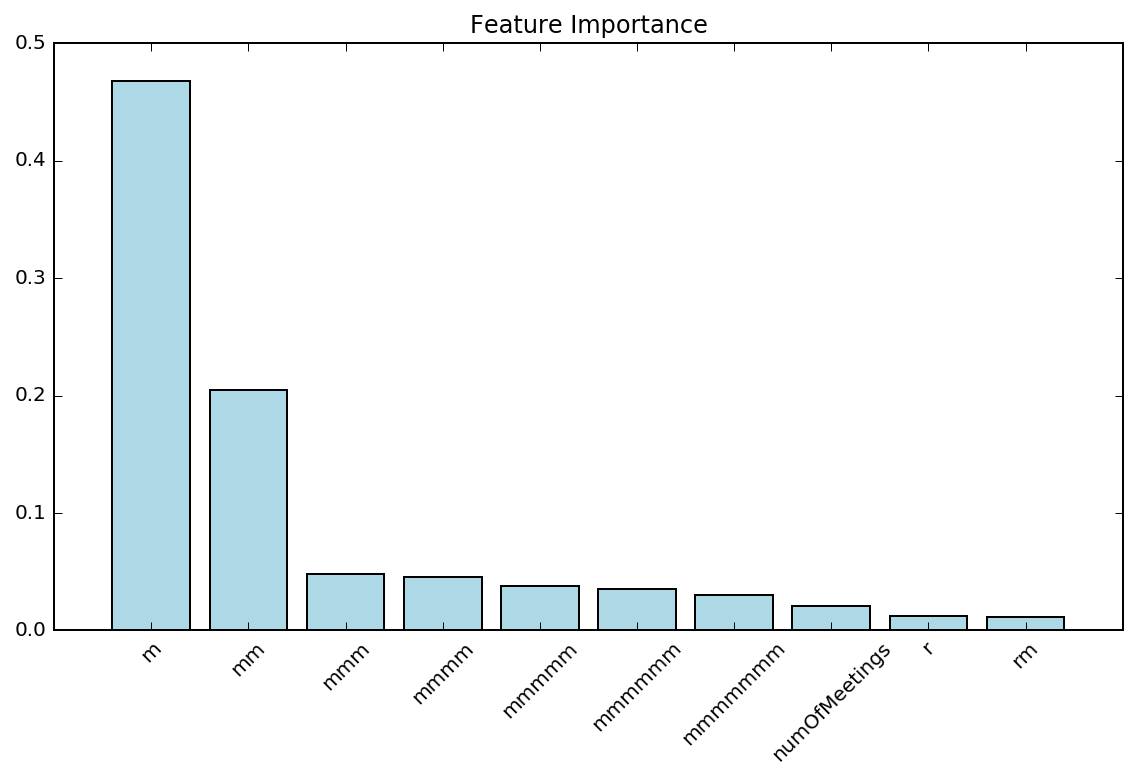

In [13]:
indices = np.argsort(rbestClf.feature_importances_)[::-1]

# list features and scores
#for f in range(X_train.shape[1]):
#    print("%2d) %-*s %f" % (f+1, 30, X_train.columns[f], bestClf.feature_importances_[indices[f]]))

# plot bar chart
plt.title('Feature Importance')
plt.bar(range(10),
       rbestClf.feature_importances_[indices[:10]],
       color='lightblue',
       align='center')
plt.xticks(range(10),
          X_train.columns, rotation=45)
plt.xlim([-1, 10])
plt.tight_layout()
plt.show()